In [125]:
#Import all the relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

In [126]:
#Set up user defined constants and file info
NCmetadatafile = '220211_2M1F_NaiveChoice_metadata.csv'
FCmetadatafile = '220211_2F1M_final_metadata.csv'
huddle_time = 20 #ms
PPI_floor = 0.75 #value taken from Kim

make_duplicate_plots = True

In [137]:
#Define support functions in this cell
def check_files_versus_metadata():
    return

def extract_lane_info(file_list):
    extracted_names = []
    for file in range(0, len(file_list),1):
        components = file_list[file].split('_')
        for l in range(0, len(components),1):
            if "Lane" in components[l]:
                extracted_names.append(components[l])
    return extracted_names

def adjacent_columns(file_list):
    num_adjacentcolumns = []
    names = extract_lane_info(file_list)
    for name in names:
        if re.search('Lane1|Lane4', name):
            num_adjacentcolumns.append(1)
        else:
            num_adjacentcolumns.append(2)
    return num_adjacentcolumns
    
def calculate_PPI(datafile):
    #calculate time huddling
    time_huddling_right = []
    time_huddling_left = []
    for i in range(0, len(datafile),1):
        row = datafile.loc[i]
        timecontactright = row.Contact_Right_stop - row.Contact_Right_start
        timecontactleft = row.Contact_Left_stop - row.Contact_Left_start
        if timecontactright >= huddle_time:
            time_huddling_right.append(timecontactright)
        if timecontactleft >= huddle_time:
            time_huddling_left.append(timecontactleft)
    total_huddle_time_right = np.nansum(time_huddling_right)
    total_huddle_time_left = np.nansum(time_huddling_left)
    PPI = (total_huddle_time_right - total_huddle_time_left)/(total_huddle_time_right + total_huddle_time_left)
    return PPI

def calculate_winner(datafile):
    if calculate_PPI(datafile) >= PPI_floor:
        return 'Right'
    elif calculate_PPI(datafile) <= -(PPI_floor):
        return 'Left'
    else:
        return 'None'
    
#PLOTTING FUNCTIONS
    
def relplot (datatable, xaxis, yaxis, plottype = 'scatter'):
    #Unless specified, default relplot is scatter
    sns.relplot(
    data = datatable, kind = plottype,
    x = xaxis, y = yaxis, #col = "time", 
    #hue = "Left", style = 'Left', size = 'size'
    )
    return
def displot(datatable, xaxis, yaxis, plottype = 'hist'):
    #Unless specified, default displot is histogram
    sns.displot(
        data = datatable, 
        kind = plottype, 
        x = xaxis,
        y = yaxis, #col = "time", 
    #hue = "Left", style = 'Left', size = 'size'
    )
    return


In [163]:
#Handle the raw data files for naive choice

# 1 - Generate a list of all the files to work on
#Import metadata as a DataFrame
NCmetadatatable = pd.read_csv(NCmetadatafile)

#Define the file path for this data files
data_dir = os.path.join('C:\\','Users','vashv','OneDrive','Documents','GitHub','ppt-lanes','data_files')


#Create a list of files for this project
NC_all_files = []
NC_all_files += [os.path.join(data_dir, each) for each in os.listdir(data_dir) if 'NaiveChoice' in each]



# 2 - Set up places to store all your eventual calculations
winner_column = []
PPI_column = []

# 3 - Iterate over that list

for file in NC_all_files:
    #Load data
    thisdata = pd.read_csv(file)
    #do all computations by calling functions
    thisPPI = calculate_PPI(thisdata)
    thiswinner = calculate_winner(thisdata)
    #put all of my file calculations in group data table
    PPI_column.append(thisPPI)
    winner_column.append(thiswinner)

# Consolidate all your calculations into one big table

NCtable = NCmetadatatable.drop(6)
#Above done because data is missing
NCtable.insert(loc = 0,
              column = 'Lane',
              value = extract_lane_info(NC_all_files))
NCtable.insert(loc = 1,
              column = '# Adjacent Columns',
              value = adjacent_columns(NC_all_files))
NCtable['PPI'] = PPI_column
NCtable.insert(loc = 7,
               column = 'Absolute PPI',
               value = abs(NCtable['PPI']))
NCtable['Winner'] = winner_column
NCtable = NCtable.drop('File.name', axis = 1)
NCtable.to_csv('Summary_table_NC')

#Compared to Nerissa - you need to calculate winner and all that for everything, and resave - eh just fix???

In [167]:
#Maybe rewrite the way that Nerissa recommended with a summary table for every recording day?
NCtable

,Lane,# Adjacent Columns,Left,Right,Sex,PPI,Absolute PPI,Winner
0,Lane1,1,WT,Oxtr-/-,2M1F,0.974477,0.974477,Right
1,Lane2,2,WT,WT,2M1F,0.817165,0.817165,Right
2,Lane3,2,Oxtr-/-,WT,2M1F,1.000000,1.000000,Right
3,Lane4,1,WT,WT,2M1F,0.134985,0.134985,None
4,Lane1,1,Oxtr-/-,WT,2M1F,0.739965,0.739965,None
5,Lane2,2,WT,WT,2M1F,0.442490,0.442490,None
7,Lane4,1,Oxtr-/-,WT,2M1F,0.909047,0.909047,Right
8,Lane1,1,WT,WT,2M1F,-0.651902,0.651902,None
9,Lane2,2,WT,Oxtr-/-,2M1F,0.448250,0.448250,None
10,Lane4,1,WT,Oxtr-/-,2M1F,-0.820928,0.820928,Left


In [171]:
#Rerun analysis pipeline for FC
#Import metadata as a DataFrame
FCmetadatatable = pd.read_csv(FCmetadatafile)

#Define the file path for this data files (should be the same as above)
data_dir = os.path.join('C:\\','Users','vashv','OneDrive','Documents','GitHub','ppt-lanes','data_files')


#Create a list of files for this project
FC_all_files = []
FC_all_files += [os.path.join(data_dir, each) for each in os.listdir(data_dir) if 'final' in each]

# 2 - Set up places to store all your eventual calculations
winner_column_FC = []
PPI_column_FC = []

# 3 - Iterate over that list

for file in FC_all_files:
    #Load data
    thisdata = pd.read_csv(file)
    #do all computations by calling functions
    thisPPI = calculate_PPI(thisdata)
    thiswinner = calculate_winner(thisdata)
    #put all of my file calculations in group data table
    PPI_column_FC.append(thisPPI)
    winner_column_FC.append(thiswinner)

# Consolidate all your calculations into one big table

FCtable = FCmetadatatable.drop('Done?', axis = 1)
FCtable.insert(loc = 0,
              column = 'Lane',
              value = extract_lane_info(FC_all_files))
FCtable.insert(loc = 1,
              column = '# Adjacent Columns',
              value = adjacent_columns(FC_all_files))
FCtable['PPI'] = PPI_column_FC
FCtable.insert(loc = 7,
               column = 'Absolute PPI',
               value = abs(FCtable['PPI']))
FCtable['Winner'] = winner_column_FC
FCtable = FCtable.drop('File.name', axis = 1)
FCtable.to_csv('Summary_table_FC')

FCtable

,Lane,# Adjacent Columns,Left,Right,Sex,PPI,Absolute PPI,Winner
0,Lane1,1,WT,WT,F,-0.954829,0.954829,Left
1,Lane2,2,Oxtr-/-,WT,F,0.284248,0.284248,None
2,Lane1,1,WT,WT,F,-0.218244,0.218244,None
3,Lane2,2,Oxtr-/-,WT,F,0.844684,0.844684,Right
4,Lane1,1,Oxtr-/-,WT,F,1.000000,1.000000,Right
5,Lane2,2,WT,WT,F,0.911561,0.911561,Right
6,Lane3,2,WT,Oxtr-/-,F,0.742581,0.742581,None
7,Lane4,1,WT,WT,F,0.919426,0.919426,Right
8,Lane3,2,Oxtr-/-,WT,F,0.973030,0.973030,Right
9,Lane4,1,WT,WT,F,-0.682883,0.682883,None


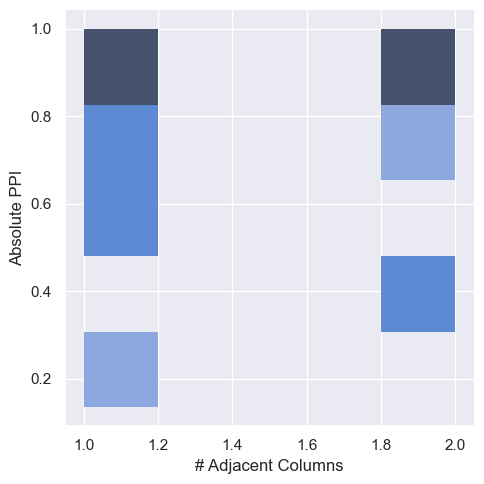

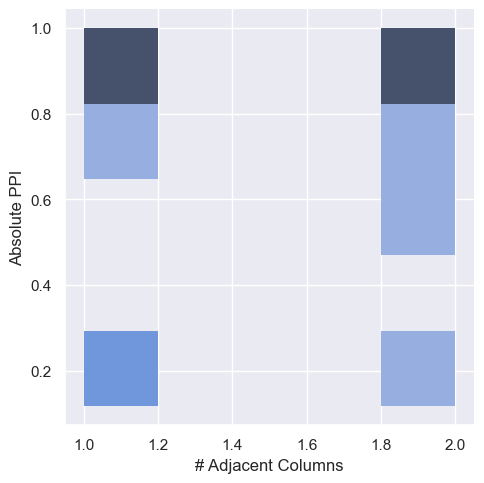

In [172]:
#---MAKE SOME PLOTS WITH DATA TABLES---

#lOAD RELEVANT DATA TABLES
NCsummary = pd.read_csv('Summary_table_NC')
FCsummary = pd.read_csv('Summary_table_FC')

#Plot that data
sns.set_theme()

#NCsummary.plot(x = '# Adjacent Columns', y = 'PPI', style = 'o')
displot(NCsummary, "# Adjacent Columns", 'Absolute PPI')
displot(FCsummary, '# Adjacent Columns', 'Absolute PPI')

In [ ]:
#Want to plot